<h1 align="center">Age estimation using an CNN, ensemble of models and the attention mechanism</h1>

### Description of the problem:

Automatic age estimation from face images is one of the most popular and complex tasks with different applications. For example, managing the content of viewed media files depending on the age of the client.
Automatic age estimation is a complex process because the aging process in humans is not uniform.
In this work, I will try to train several neural networks using the popular UTKFaces set, including using the attention mechanism, and compare the results of their work.

#### Required imports

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, CategoryEncoding, AveragePooling2D,\
                                    Dropout, BatchNormalization, AveragePooling2D, GlobalMaxPool2D,\
                                    MultiHeadAttention, Input
from tensorflow.keras.regularizers import l2
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, load_model, Model

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError
import tensorflow as tf

from tensorflow.keras.layers import Concatenate, Input

pd.set_option('display.max_rows', 30)

from tensorflow.keras.applications import VGG16, MobileNet
from tensorflow.keras.utils import plot_model 

import gc

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [2]:
results_frame = pd.DataFrame(columns=['model_name','val_mae','test_mae'])

In [3]:
### Function for plotting the training graph on the training and training set:def test_val_graph (history,train,val):
def test_val_graph (history,train,val):
    plt.plot(history.history[train], label='Accuracy on the training set')
    plt.plot(history.history[val], label='Accuracy on test set')
    plt.xlabel('Learning cycle')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    pass;

# Part 1. Data preparation

#### 01. Uploading files.

Since the entire dataset is represented by separate .jpg files, for further work we need to compile a list of them and save it in .csv format.
Where can I get information about the age of the people shown in the photo? "1_0_0_20161219140623097.jpg.chip", then the first digits will correspond to the person's age. Therefore, we split on the underscore and enter this data in the table as well.

In [4]:
df = pd.DataFrame() ### Create an empty Dataframe

for file_name in tqdm(os.listdir('E:\\UTKFace\\')):
    #forming a link to the image
    link = 'E:\\UTKFace\\' + file_name
    
    name = file_name[:-4] #remove the file extension from the name
    age = name.split('_')[0] #s plit on underscore and select date
            
    #form a temporary dataframe
    data = pd.DataFrame({'link': [str(link)],
                         'age': [int(age)]})
            #We do concatenation with the main dataframe.
    df = pd.concat([df,data], axis=0)

df.to_csv('data_UTK.csv',
          index=False)

100%|██████████| 23708/23708 [00:15<00:00, 1567.41it/s]


#### 02. Load the dataset

In [5]:
df = pd.read_csv ('data_UTK.csv')

In [6]:
df

,link,age
0,E:\UTKFace\100_0_0_20170112213500903.jpg.chip.jpg,100
1,E:\UTKFace\100_0_0_20170112215240346.jpg.chip.jpg,100
2,E:\UTKFace\100_1_0_20170110183726390.jpg.chip.jpg,100
3,E:\UTKFace\100_1_0_20170112213001988.jpg.chip.jpg,100
4,E:\UTKFace\100_1_0_20170112213303693.jpg.chip.jpg,100
...,...,...
23703,E:\UTKFace\9_1_3_20161220222856346.jpg.chip.jpg,9
23704,E:\UTKFace\9_1_3_20170104222949455.jpg.chip.jpg,9
23705,E:\UTKFace\9_1_4_20170103200637399.jpg.chip.jpg,9
23706,E:\UTKFace\9_1_4_20170103200814791.jpg.chip.jpg,9


#### Display random 25 images from the resulting list

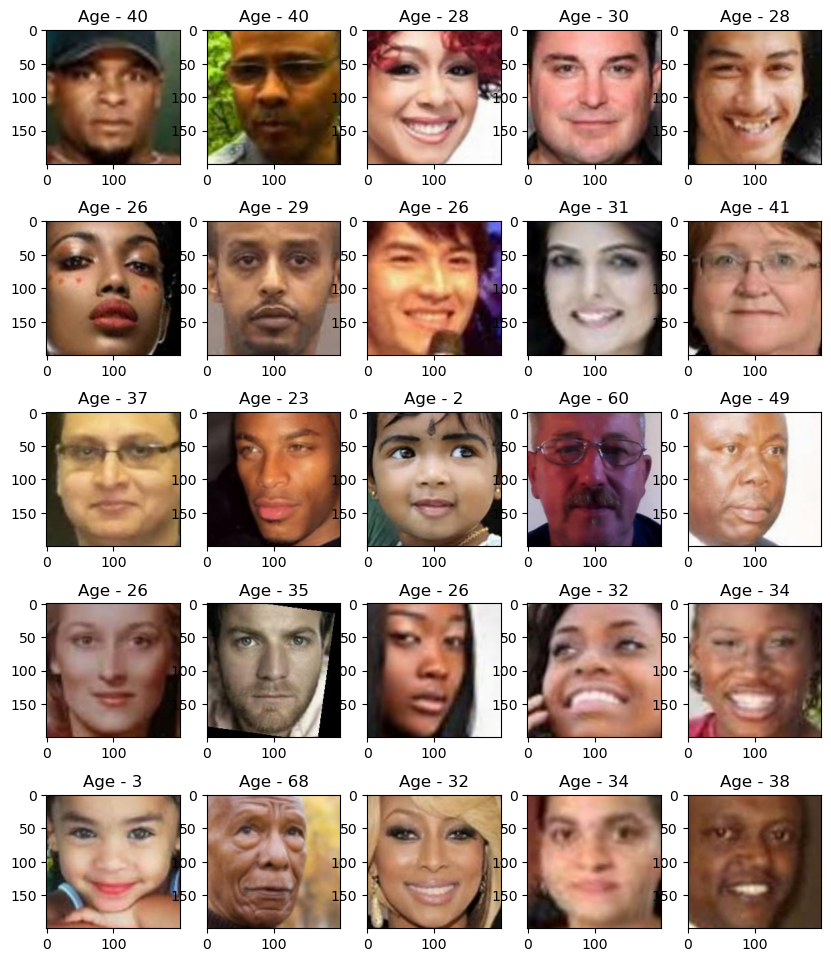

In [7]:
idx = np.random.randint (0,len(df),25)
plt.figure(figsize=(10,12))
for idx in enumerate(idx):
    plt.subplot (5,5,idx[0]+1)
    link = df.iloc[idx[1]]
    image = plt.imread(link[0])
    title = 'Age - ' + str(link[1])
    plt.title (title)
    plt.imshow(image, cmap='gray');

#### 03. Loading the set. We form a training and test set

In [8]:
train, test = train_test_split(df, test_size=0.1, random_state=34)

#### 04. Create a generator

In [9]:
train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.3)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [10]:
TARGET_SIZE = (128,128)
BATCH_SIZE = 8

train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="link",
y_col="age",
subset="training",
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="link",
y_col="age",
subset="validation",
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="./",
x_col="link",
y_col="age",
batch_size=BATCH_SIZE,
seed=42,
shuffle=False,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

Found 14936 validated image filenames.
Found 6401 validated image filenames.
Found 2371 validated image filenames.


# Part 2: Train the Model

#### 01. Architecting a simple convolutional network

In [11]:
#### Create model architecture
model_conv = Sequential()

model_conv.add (Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(128,128,3)))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))
model_conv.add (BatchNormalization())

model_conv.add (Conv2D(128, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))
model_conv.add (BatchNormalization())

model_conv.add (Conv2D(256, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))
model_conv.add (BatchNormalization())

model_conv.add (Conv2D(512, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))
model_conv.add (BatchNormalization())

model_conv.add (Conv2D(512, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))
model_conv.add (BatchNormalization())

model_conv.add(GlobalMaxPool2D())

model_conv.add(Dense(1000, activation='relu'))
model_conv.add(Dropout(0.7))

model_conv.add(Dense(1, activation='linear'))

model_conv.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

In [12]:
model_conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                        

Epoch 1/20
1867/1867 [==============================] - 145s 75ms/step - loss: 243.0962 - mae: 11.7756 - val_loss: 130.3151 - val_mae: 8.4803 - lr: 1.0000e-04
Epoch 2/20
1867/1867 [==============================] - 57s 30ms/step - loss: 136.2130 - mae: 8.8275 - val_loss: 99.3040 - val_mae: 7.4064 - lr: 1.0000e-04
Epoch 3/20
1867/1867 [==============================] - 57s 31ms/step - loss: 103.4576 - mae: 7.6521 - val_loss: 87.7585 - val_mae: 6.9549 - lr: 1.0000e-04
Epoch 4/20
1867/1867 [==============================] - 57s 31ms/step - loss: 85.3226 - mae: 6.9411 - val_loss: 81.8044 - val_mae: 6.6154 - lr: 1.0000e-04
Epoch 5/20
1867/1867 [==============================] - 57s 31ms/step - loss: 73.7821 - mae: 6.4860 - val_loss: 83.4169 - val_mae: 6.8860 - lr: 1.0000e-04
Epoch 6/20
1867/1867 [==============================] - 58s 31ms/step - loss: 61.8891 - mae: 5.9824 - val_loss: 82.0688 - val_mae: 6.5041 - lr: 1.0000e-04
Epoch 7/20
1867/1867 [==============================] - 57s 31ms

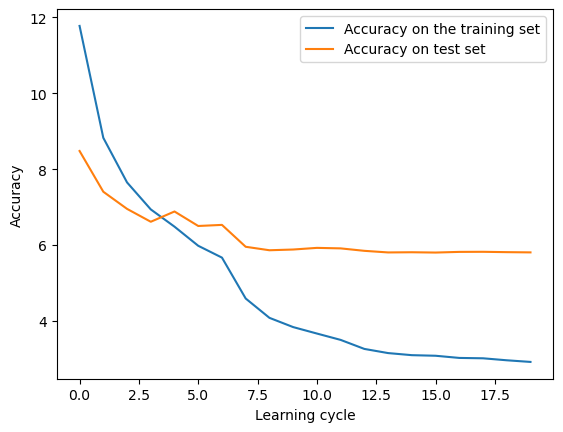

In [13]:
#### Set callbacks
checkpoint_cb_conv = ModelCheckpoint("model_conv.h5", 
                                     monitor = 'val_mae',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=3)

#### Train the model
history_model_conv = model_conv.fit(train_generator,
                          validation_data=valid_generator,
                          callbacks=[checkpoint_cb_conv,lr_scheduler],
                          epochs=20)

test_val_graph (history_model_conv,'mae','val_mae')

In [14]:
results = model_conv.evaluate (test_generator)

297/297 [==============================] - 17s 59ms/step - loss: 61.4461 - mae: 5.6581


In [15]:
val_mae = np.min(history_model_conv.history['val_mae'])
test_mae = results[1]

data = pd.DataFrame({'model_name': ['model_conv'],
                     'val_mae':   [val_mae],
                     'test_mae':  [test_mae]})
results_frame = pd.concat ([results_frame, data], axis=0)
results_frame.to_csv('results_frame.csv',
                      index=False)

In [16]:
del model_conv
gc.collect()

3803

#### 02. Convolutional network + attention mechanism

In [17]:
input_layer = Input(shape=(128,128,3))

conv_layer1 = Conv2D(64, (3,3), padding='same', activation='relu')(input_layer)
max_pool1 = MaxPooling2D(pool_size=(2,2), strides=2)(conv_layer1)
batch_norm1 = BatchNormalization()(max_pool1)

conv_layer2 = Conv2D(128, (3,3), padding='same', activation='relu')(batch_norm1)
max_pool2 = MaxPooling2D(pool_size=(2,2), strides=2)(conv_layer2)
batch_norm2 = BatchNormalization()(max_pool2)

conv_layer3 = Conv2D(256, (3,3), padding='same', activation='relu')(batch_norm2)
max_pool3 = MaxPooling2D(pool_size=(2,2), strides=2)(conv_layer3)
batch_norm3 = BatchNormalization()(max_pool3)

conv_layer4 = Conv2D(512, (3,3), padding='same', activation='relu')(batch_norm3)
max_pool4 = MaxPooling2D(pool_size=(2,2), strides=2)(conv_layer4)
batch_norm4 = BatchNormalization()(max_pool4)

conv_layer5 = Conv2D(512, (3,3), padding='same', activation='relu')(batch_norm4)
max_pool5 = MaxPooling2D(pool_size=(2,2), strides=2)(conv_layer5)
batch_norm5 = BatchNormalization()(max_pool5)

global_max_pool = GlobalMaxPool2D()(batch_norm5)

dense_1 = Dense(1000, activation='relu')(global_max_pool)
drop_1 = Dropout(0.7)(dense_1)

multi_head = MultiHeadAttention(num_heads=12, key_dim=256, attention_axes=(0, 1))(drop_1, drop_1)
drop_2 = Dropout(0.7)(multi_head)

output_layer = Dense(1, activation='linear')(drop_2)

model_conv_attention = Model(inputs=input_layer, outputs=output_layer, name='Model_conv_attention')

In [18]:
model_conv_attention.summary()

Model: "Model_conv_attention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 64, 64, 64)  0           ['conv2d_5[0][0]']               
                                                                               

Epoch 1/20
1867/1867 [==============================] - 66s 35ms/step - loss: 331.7289 - mae: 13.8411 - val_loss: 217.8464 - val_mae: 10.7807 - lr: 1.0000e-04
Epoch 2/20
1867/1867 [==============================] - 65s 35ms/step - loss: 199.2683 - mae: 10.4914 - val_loss: 137.1686 - val_mae: 8.6847 - lr: 1.0000e-04
Epoch 3/20
1867/1867 [==============================] - 64s 34ms/step - loss: 160.6342 - mae: 9.4231 - val_loss: 204.2538 - val_mae: 10.8674 - lr: 1.0000e-04
Epoch 4/20
1867/1867 [==============================] - 64s 34ms/step - loss: 131.1790 - mae: 8.5190 - val_loss: 94.7230 - val_mae: 7.0522 - lr: 1.0000e-04
Epoch 5/20
1867/1867 [==============================] - 64s 34ms/step - loss: 121.1844 - mae: 8.0942 - val_loss: 161.7370 - val_mae: 9.9350 - lr: 1.0000e-04
Epoch 6/20
1867/1867 [==============================] - 65s 35ms/step - loss: 104.3088 - mae: 7.5358 - val_loss: 78.1153 - val_mae: 6.3029 - lr: 1.0000e-04
Epoch 7/20
1867/1867 [==============================] - 

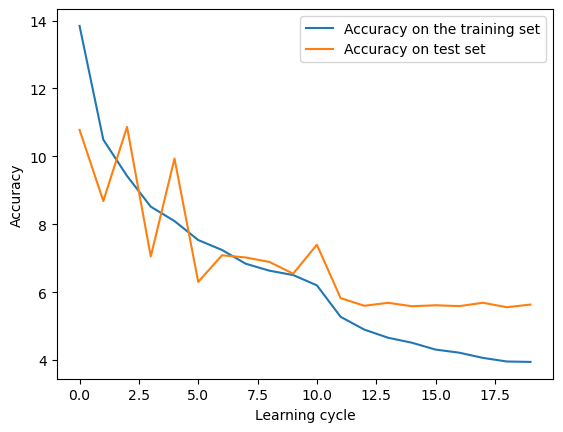

In [19]:
model_conv_attention.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

checkpoint_cb_conv = ModelCheckpoint("model_conv_attention.h5", 
                                     monitor = 'val_mae',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, 
                                 patience=5,  
                                 monitor = 'val_mae')

history_model_conv_attention = model_conv_attention.fit(train_generator,
                                                       validation_data=valid_generator,
                                                       callbacks=[checkpoint_cb_conv,lr_scheduler],
                                                       epochs=20)

test_val_graph (history_model_conv_attention,'mae','val_mae')

In [20]:
results = model_conv_attention.evaluate (test_generator)

297/297 [==============================] - 4s 13ms/step - loss: 57.2910 - mae: 5.4390


In [21]:
val_mae = np.min(history_model_conv_attention.history['val_mae'])
test_mae = results[1]

data = pd.DataFrame({'model_name': ['model_conv_attention'],
                     'val_mae':   [val_mae],
                     'test_mae':  [test_mae]})
results_frame = pd.concat ([results_frame, data], axis=0)
results_frame.to_csv('results_frame.csv',
                      index=False)

In [22]:
del model_conv_attention
gc.collect()

4267

#### 03. Pretrained VGG16 network

In [23]:
vgg16 = VGG16(input_shape=(128,128,3), weights='imagenet', include_top=False) 

for i in vgg16.layers[:-3]:
    i.trainable = False 

# build model 
input = vgg16.layers[-1].output # input is the last output from vgg16 

x = Flatten()(input) 
x = Dense(1000, activation='relu')(x)
x = Dropout(0.7)(x)

output = Dense(1, activation='linear')(x) 

# create the model 
vgg16_model = Model(vgg16.input, output, name='VGG16_Model')

In [24]:
vgg16_model.summary()

Model: "VGG16_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       

Epoch 1/20
1867/1867 [==============================] - 66s 34ms/step - loss: 155.1434 - mae: 9.1593 - val_loss: 103.5699 - val_mae: 7.2246 - lr: 5.0000e-04
Epoch 2/20
1867/1867 [==============================] - 64s 34ms/step - loss: 110.3345 - mae: 7.6729 - val_loss: 94.7357 - val_mae: 7.1406 - lr: 5.0000e-04
Epoch 3/20
1867/1867 [==============================] - 64s 34ms/step - loss: 95.2161 - mae: 7.0824 - val_loss: 91.4940 - val_mae: 7.0672 - lr: 5.0000e-04
Epoch 4/20
1867/1867 [==============================] - 63s 34ms/step - loss: 83.7896 - mae: 6.7327 - val_loss: 82.5458 - val_mae: 6.4630 - lr: 5.0000e-04
Epoch 5/20
1867/1867 [==============================] - 63s 34ms/step - loss: 76.1709 - mae: 6.3822 - val_loss: 85.3604 - val_mae: 6.6001 - lr: 5.0000e-04
Epoch 6/20
1867/1867 [==============================] - 63s 34ms/step - loss: 68.2155 - mae: 6.0663 - val_loss: 82.4376 - val_mae: 6.4326 - lr: 5.0000e-04
Epoch 7/20
1867/1867 [==============================] - 63s 34ms/st

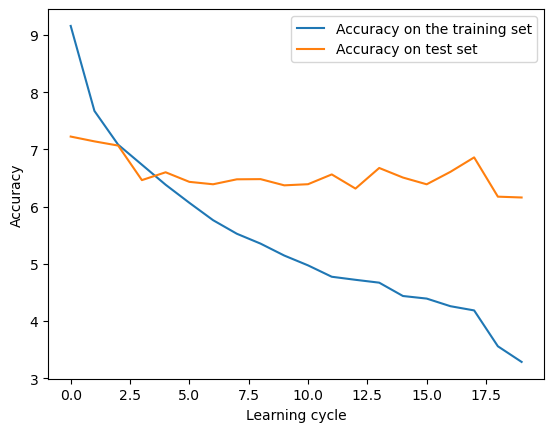

In [25]:
vgg16_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

checkpoint_cb_conv = ModelCheckpoint("vgg16_model.h5", 
                                     monitor = 'val_mae',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, 
                                 patience=5,  
                                 monitor = 'val_mae')

history_vgg16 = vgg16_model.fit(train_generator,
                           validation_data=valid_generator,
                           callbacks=[checkpoint_cb_conv,lr_scheduler],
                           epochs=20)

test_val_graph (history_vgg16,'mae','val_mae')

In [26]:
results = vgg16_model.evaluate (test_generator)

297/297 [==============================] - 6s 21ms/step - loss: 74.2315 - mae: 6.1441


In [27]:
val_mae = np.min(history_vgg16.history['val_mae'])
test_mae = results[1]

data = pd.DataFrame({'model_name': ['vgg16_model'],
                     'val_mae':   [val_mae],
                     'test_mae':  [test_mae]})
results_frame = pd.concat ([results_frame, data], axis=0)
results_frame.to_csv('results_frame.csv',
                      index=False)

In [28]:
del vgg16_model
gc.collect()

4015

#### 04. VGG16 + attention mechanism

In [29]:
vgg16 = VGG16(input_shape=(128,128,3), weights='imagenet', include_top=False) 

for i in vgg16.layers[:-3]:
    i.trainable = False 

# build model 
input = vgg16.layers[-1].output # input is the last output from vgg16 

x = Flatten()(input) 
x = Dense(1000, activation='relu')(x)
x = Dropout(0.5)(x)

x = MultiHeadAttention(num_heads=12, key_dim=256, attention_axes=(0, 1))(x, x)
x = Dropout(0.5)(x)

output = Dense(1, activation='linear')(x) 

# create the model 
vgg16_model_attention = Model(vgg16.input, output, name='VGG16_model_attention')

In [30]:
vgg16_model_attention.summary()

Model: "VGG16_model_attention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                             

Epoch 1/20
1867/1867 [==============================] - 73s 39ms/step - loss: 242.2160 - mae: 11.5340 - val_loss: 140.8435 - val_mae: 9.4652 - lr: 5.0000e-04
Epoch 2/20
1867/1867 [==============================] - 72s 38ms/step - loss: 130.3491 - mae: 8.4310 - val_loss: 98.5057 - val_mae: 7.2608 - lr: 5.0000e-04
Epoch 3/20
1867/1867 [==============================] - 72s 38ms/step - loss: 110.2171 - mae: 7.7745 - val_loss: 91.8428 - val_mae: 6.8797 - lr: 5.0000e-04
Epoch 4/20
1867/1867 [==============================] - 72s 38ms/step - loss: 102.6613 - mae: 7.4809 - val_loss: 91.1201 - val_mae: 6.7329 - lr: 5.0000e-04
Epoch 5/20
1867/1867 [==============================] - 71s 38ms/step - loss: 93.9671 - mae: 7.1767 - val_loss: 90.8476 - val_mae: 6.9577 - lr: 5.0000e-04
Epoch 6/20
1867/1867 [==============================] - 72s 38ms/step - loss: 84.9417 - mae: 6.8191 - val_loss: 84.9888 - val_mae: 6.5335 - lr: 5.0000e-04
Epoch 7/20
1867/1867 [==============================] - 71s 38ms

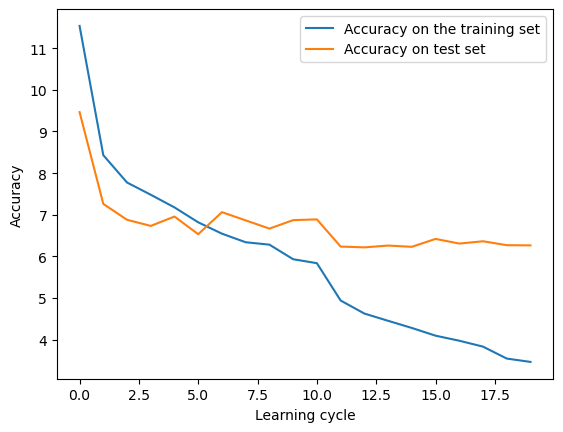

In [31]:
vgg16_model_attention.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

checkpoint_cb_conv = ModelCheckpoint("vgg16_model_attention.h5", 
                                     monitor = 'val_mae',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, 
                                 patience=5,  
                                 monitor = 'val_mae')

history_vgg16_attention = vgg16_model_attention.fit(train_generator,
                           validation_data=valid_generator,
                           callbacks=[checkpoint_cb_conv,lr_scheduler],
                           epochs=20)

test_val_graph (history_vgg16_attention,'mae','val_mae')

In [32]:
results = vgg16_model_attention.evaluate (test_generator)

297/297 [==============================] - 9s 29ms/step - loss: 79.4174 - mae: 6.2622


In [33]:
val_mae = np.min(history_vgg16_attention.history['val_mae'])
test_mae = results[1]

data = pd.DataFrame({'model_name': ['vgg16_model_attention'],
                     'val_mae':   [val_mae],
                     'test_mae':  [test_mae]})
results_frame = pd.concat ([results_frame, data], axis=0)
results_frame.to_csv('results_frame.csv',
                      index=False)

In [34]:
del vgg16_model_attention
gc.collect()

4078

##### 05. Concatenate the two best models

In [35]:
results_frame = pd.read_csv ('results_frame.csv')

In [36]:
model_conv_attention = load_model("model_conv_attention.h5")
model_conv = load_model("model_conv.h5")

In [37]:
models = [model_conv_attention, model_conv]

input = Input(shape=(128, 128, 3))

outputs = [model(input) for model in models]

# contenate the ouputs
x = Concatenate()(outputs) 

# add further layers
x = Dense(100, activation='relu')(x)
x = Dropout(0.7)(x) 

output = Dense(1, activation='linear')(x) # output layer

# create concatenated model
conc_model = Model(input, output)

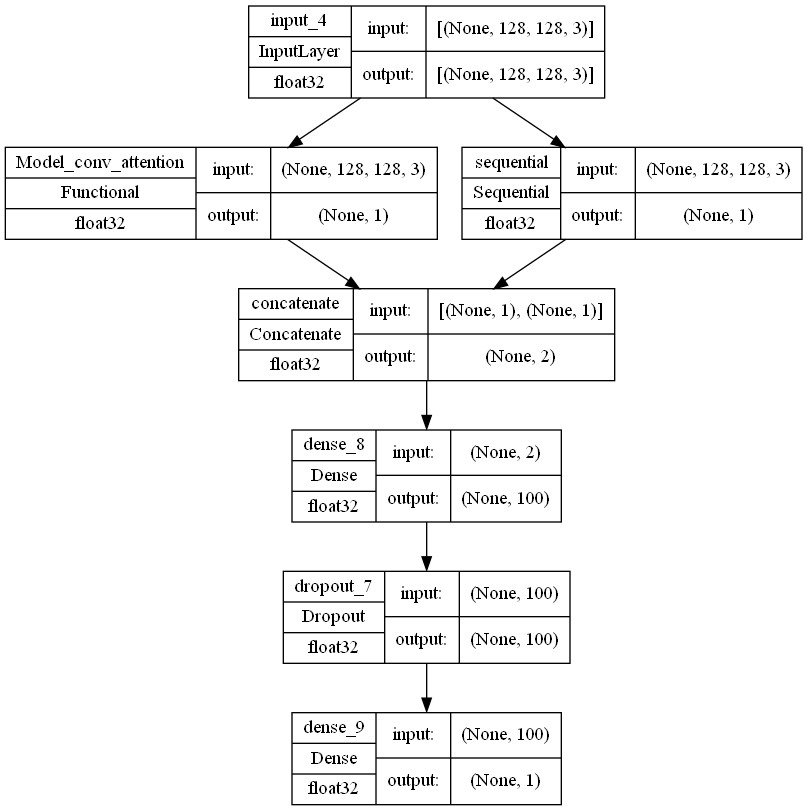

In [38]:
plot_model(conc_model,show_shapes=True,
    show_dtype=True,
    show_layer_names=True)

In [39]:
conc_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Model_conv_attention (Function  (None, 1)           16728889    ['input_4[0][0]']                
 al)                                                                                              
                                                                                                  
 sequential (Sequential)        (None, 1)            4430673     ['input_4[0][0]']                
                                                                                              

In [40]:
conc_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

Epoch 1/20
1867/1867 [==============================] - ETA: 0s - loss: 445.7465 - mae: 15.7995INFO:tensorflow:Assets written to: conc_model\assets


INFO:tensorflow:Assets written to: conc_model\assets


1867/1867 [==============================] - 118s 62ms/step - loss: 445.7465 - mae: 15.7995 - val_loss: 198.7847 - val_mae: 11.1903 - lr: 5.0000e-04
Epoch 2/20
1867/1867 [==============================] - ETA: 0s - loss: 244.0321 - mae: 11.6712INFO:tensorflow:Assets written to: conc_model\assets


INFO:tensorflow:Assets written to: conc_model\assets


1867/1867 [==============================] - 115s 61ms/step - loss: 244.0321 - mae: 11.6712 - val_loss: 143.7639 - val_mae: 8.6052 - lr: 5.0000e-04
Epoch 3/20
1867/1867 [==============================] - 104s 56ms/step - loss: 203.8850 - mae: 10.5873 - val_loss: 226.3098 - val_mae: 11.1251 - lr: 5.0000e-04
Epoch 4/20
1867/1867 [==============================] - ETA: 0s - loss: 182.8578 - mae: 9.9996INFO:tensorflow:Assets written to: conc_model\assets


INFO:tensorflow:Assets written to: conc_model\assets


1867/1867 [==============================] - 113s 61ms/step - loss: 182.8578 - mae: 9.9996 - val_loss: 108.4861 - val_mae: 7.8419 - lr: 5.0000e-04
Epoch 5/20
1867/1867 [==============================] - 104s 56ms/step - loss: 168.6133 - mae: 9.5839 - val_loss: 141.4332 - val_mae: 8.3689 - lr: 5.0000e-04
Epoch 6/20
1866/1867 [============================>.] - ETA: 0s - loss: 156.0222 - mae: 9.1888INFO:tensorflow:Assets written to: conc_model\assets


INFO:tensorflow:Assets written to: conc_model\assets


1867/1867 [==============================] - 114s 61ms/step - loss: 155.9874 - mae: 9.1882 - val_loss: 92.4431 - val_mae: 7.1073 - lr: 5.0000e-04
Epoch 7/20
1867/1867 [==============================] - ETA: 0s - loss: 145.4320 - mae: 8.8199INFO:tensorflow:Assets written to: conc_model\assets


INFO:tensorflow:Assets written to: conc_model\assets


1867/1867 [==============================] - 114s 61ms/step - loss: 145.4320 - mae: 8.8199 - val_loss: 92.1267 - val_mae: 6.9672 - lr: 5.0000e-04
Epoch 8/20
1866/1867 [============================>.] - ETA: 0s - loss: 131.7796 - mae: 8.3823INFO:tensorflow:Assets written to: conc_model\assets


INFO:tensorflow:Assets written to: conc_model\assets


1867/1867 [==============================] - 114s 61ms/step - loss: 131.7414 - mae: 8.3814 - val_loss: 92.4318 - val_mae: 6.7641 - lr: 5.0000e-04
Epoch 9/20
1867/1867 [==============================] - 104s 55ms/step - loss: 125.5397 - mae: 8.1848 - val_loss: 122.3657 - val_mae: 8.0602 - lr: 5.0000e-04
Epoch 10/20
1867/1867 [==============================] - ETA: 0s - loss: 118.6724 - mae: 7.9220INFO:tensorflow:Assets written to: conc_model\assets


INFO:tensorflow:Assets written to: conc_model\assets


1867/1867 [==============================] - 113s 61ms/step - loss: 118.6724 - mae: 7.9220 - val_loss: 87.6690 - val_mae: 6.6939 - lr: 5.0000e-04
Epoch 11/20
1866/1867 [============================>.] - ETA: 0s - loss: 112.4606 - mae: 7.7442INFO:tensorflow:Assets written to: conc_model\assets


INFO:tensorflow:Assets written to: conc_model\assets


1867/1867 [==============================] - 113s 61ms/step - loss: 112.4323 - mae: 7.7428 - val_loss: 73.9333 - val_mae: 6.1142 - lr: 5.0000e-04
Epoch 12/20
1867/1867 [==============================] - 104s 55ms/step - loss: 103.2175 - mae: 7.4272 - val_loss: 107.0358 - val_mae: 7.5662 - lr: 5.0000e-04
Epoch 13/20
1867/1867 [==============================] - 104s 56ms/step - loss: 97.4880 - mae: 7.2118 - val_loss: 85.2787 - val_mae: 6.5497 - lr: 5.0000e-04
Epoch 14/20
1867/1867 [==============================] - 104s 56ms/step - loss: 92.1247 - mae: 7.0112 - val_loss: 89.4379 - val_mae: 6.6983 - lr: 5.0000e-04
Epoch 15/20
1867/1867 [==============================] - ETA: 0s - loss: 90.7853 - mae: 6.9578INFO:tensorflow:Assets written to: conc_model\assets


INFO:tensorflow:Assets written to: conc_model\assets


1867/1867 [==============================] - 113s 61ms/step - loss: 90.7853 - mae: 6.9578 - val_loss: 72.0329 - val_mae: 6.1023 - lr: 5.0000e-04
Epoch 16/20
1867/1867 [==============================] - 105s 56ms/step - loss: 87.6557 - mae: 6.7840 - val_loss: 82.2684 - val_mae: 6.4932 - lr: 5.0000e-04
Epoch 17/20
1867/1867 [==============================] - ETA: 0s - loss: 80.7071 - mae: 6.5185INFO:tensorflow:Assets written to: conc_model\assets


INFO:tensorflow:Assets written to: conc_model\assets


1867/1867 [==============================] - 114s 61ms/step - loss: 80.7071 - mae: 6.5185 - val_loss: 73.7377 - val_mae: 6.0926 - lr: 5.0000e-04
Epoch 18/20
1867/1867 [==============================] - 104s 56ms/step - loss: 82.4418 - mae: 6.5670 - val_loss: 73.5502 - val_mae: 6.1429 - lr: 5.0000e-04
Epoch 19/20
1867/1867 [==============================] - 105s 56ms/step - loss: 76.7561 - mae: 6.3921 - val_loss: 91.3961 - val_mae: 6.8071 - lr: 5.0000e-04
Epoch 20/20
1867/1867 [==============================] - 110s 59ms/step - loss: 76.1497 - mae: 6.3387 - val_loss: 77.5571 - val_mae: 6.2724 - lr: 5.0000e-04


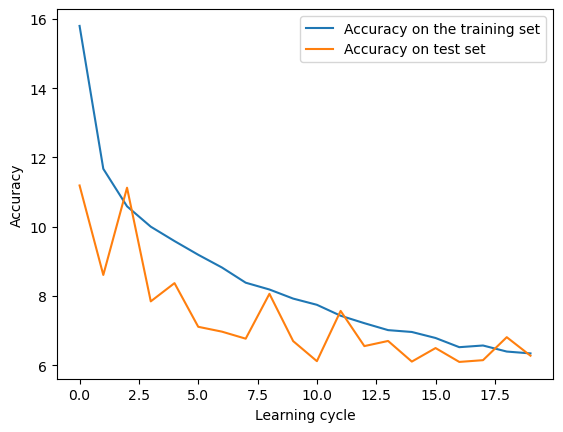

In [41]:
checkpoint_cb_conv = ModelCheckpoint("conc_model", 
                                     monitor = 'val_mae',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, 
                                 patience=5,  
                                 monitor = 'val_mae')


history_conc  = conc_model.fit(train_generator,
                           validation_data=valid_generator,
                           callbacks=[checkpoint_cb_conv,lr_scheduler],
                           epochs=20);

test_val_graph (history_conc,'mae','val_mae')

In [42]:
results = conc_model.evaluate (test_generator)

297/297 [==============================] - 5s 15ms/step - loss: 74.1255 - mae: 6.1637


In [43]:
val_mae = np.min(history_conc.history['val_mae'])
test_mae = results[1]

data = pd.DataFrame({'model_name': ['conc_model'],
                     'val_mae':   [val_mae],
                     'test_mae':  [test_mae]})
results_frame = pd.concat ([results_frame, data], axis=0)
results_frame.to_csv('results_frame.csv',
                      index=False)

In [44]:
del conc_model
gc.collect()

70984

In [45]:
results_frame

,model_name,val_mae,test_mae
0,model_conv,5.803977,5.658141
1,model_conv_attention,5.556973,5.439017
2,vgg16_model,6.159203,6.144143
3,vgg16_model_attention,6.217780,6.262160
0,conc_model,6.092604,6.163746


# Part 3: Applying the Best Performing Model

In [46]:
model = load_model('model_conv_attention.h5')

#### 1. Trying to build a prediction based on random photos from the training set)

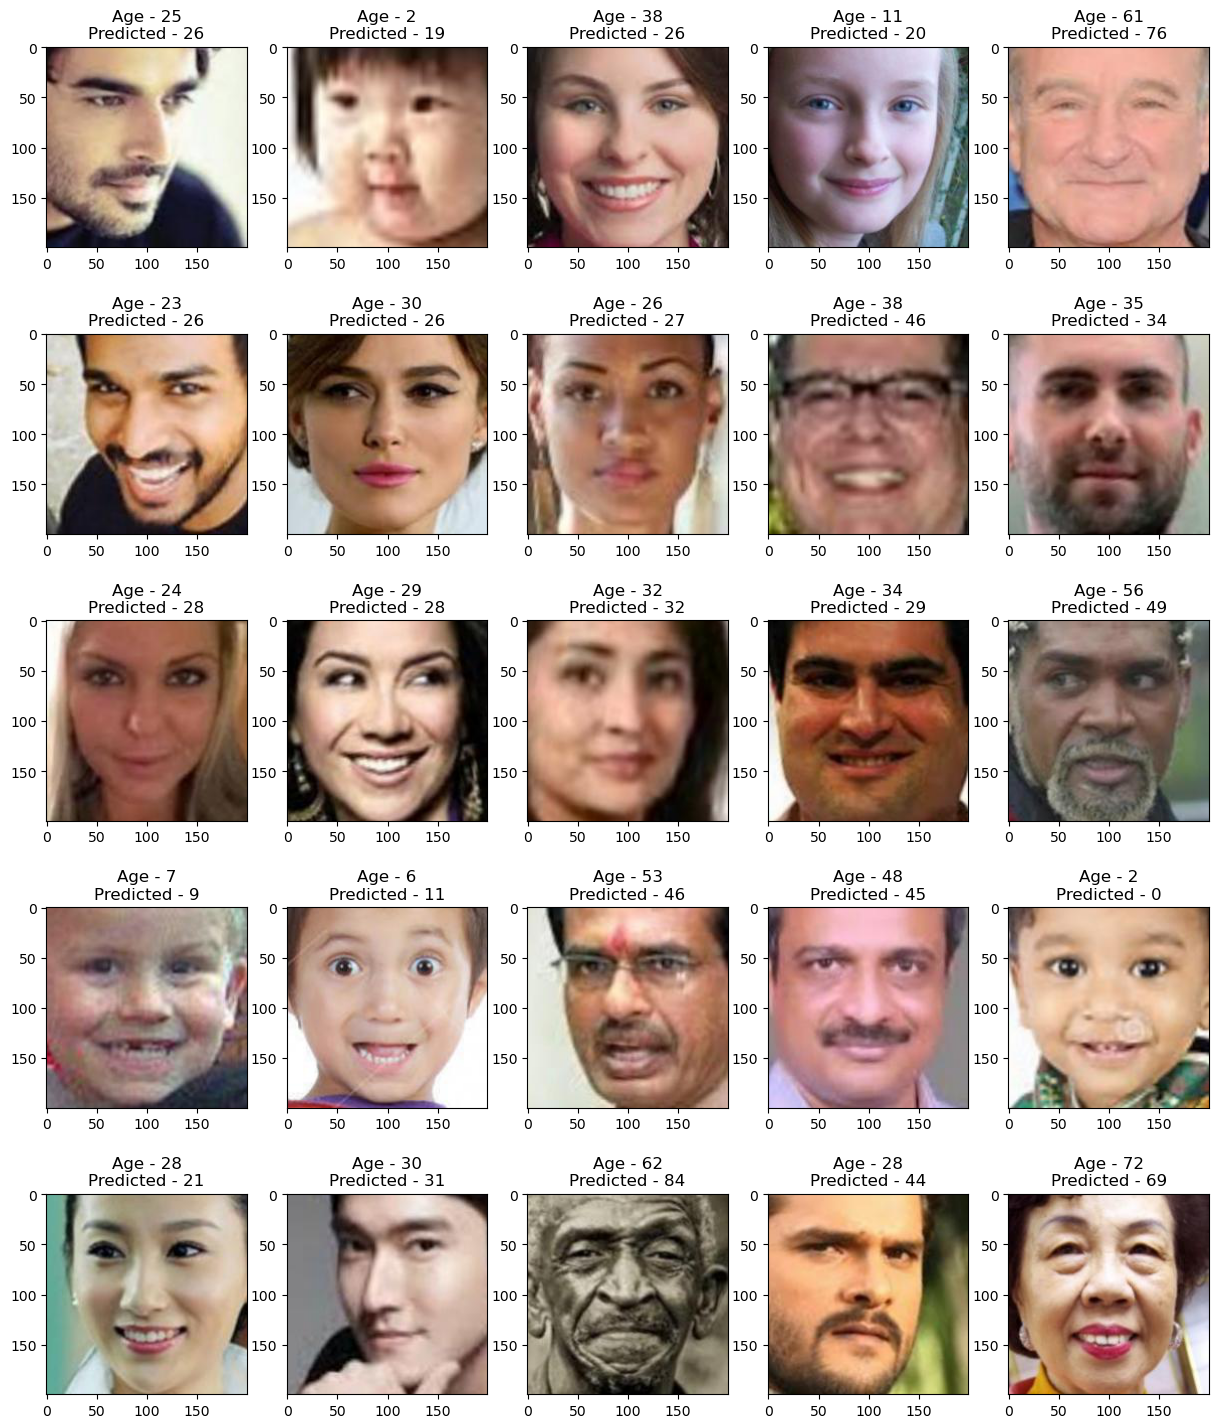

In [47]:
idx = np.random.randint (0,len(test),25)
plt.figure(figsize=(15,18))
for idx in enumerate(idx):
    plt.subplot (5,5,idx[0]+1)
    link = test.iloc[idx[1]]
    image = plt.imread(link[0])
    
    img_resized = cv2.resize (image, (128,128))/255 #,
    img_reshaped  = img_resized.reshape (1,128,128,3)
    predict = model.predict(img_reshaped, verbose=0)[0][0];
    
    title = 'Age - ' + str(link[1]) + '\nPredicted - ' + str(int(predict))
    plt.title (title)
    plt.imshow(image, cmap='gray');

#### 2. Trying to build a prediction based on the video from the webcam

In [48]:
cap = cv2.VideoCapture(1)
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
x=0
predict_avg = []
age=None

while True:
    ret, frame = cap.read()

    if x%5==0: ##### Show every fifth frame to speed up work.
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray,
                                              scaleFactor=1.1,
                                              minNeighbors=6)
        
        for x,y,w,h in faces:
            
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,255),2)
            img = frame[x:x+w,y:y+h]
            
            img_resized = cv2.resize (img, (128,128))/255 #,
            img_reshaped  = img_resized.reshape (1,128,128,3)
            predict = model.predict(img_reshaped, verbose=0)[0][0];
            
            predict_avg.append(predict)
            
            if x%10==0: #### Age is determined as the average of all values for every 10th iteration
                age = int(sum(predict_avg)/len(predict_avg))
            
            cv2.putText(frame, 
                            'Age - ' + str(age), 
                            (x, y+h+25), 
                            cv2.FONT_HERSHEY_DUPLEX, 
                            1, 
                            (0, 0, 255), 
                             2)
            
            
            cv2.imshow('frame', frame)   
            
    x+=1
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

#### An example of the resulting prediction

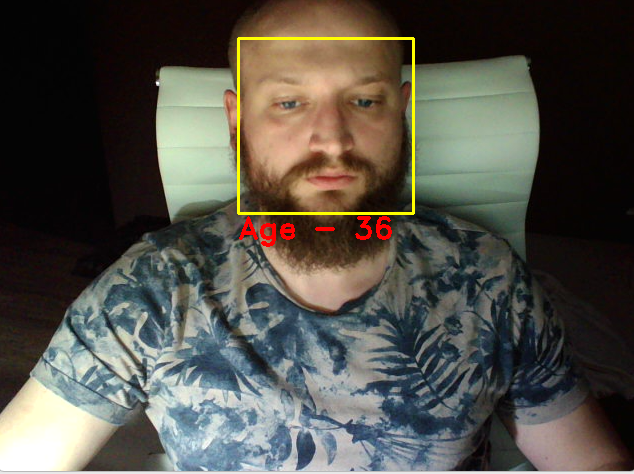


# Part 4. Conclusions

<AxesSubplot: xlabel='model_name', ylabel='val_mae'>

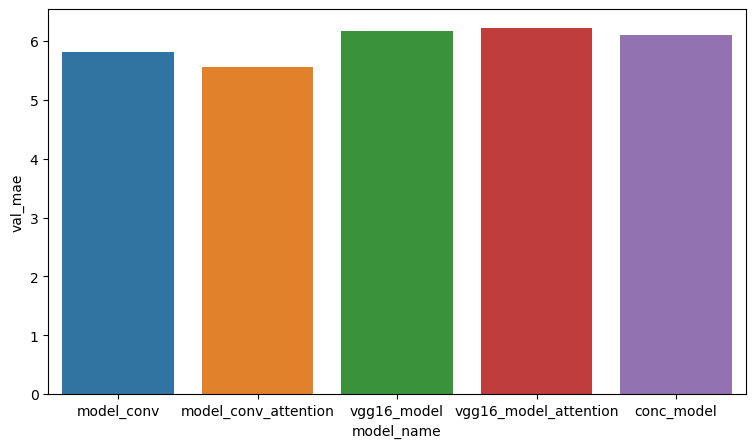

In [49]:
plt.figure(figsize=(9,5))
sns.barplot(data=results_frame, x="model_name", y="val_mae")

1. As can be seen from the presented graph, we see the smallest error value on the validation set for our own convolutional network with the connected attention mechanism from the TF package.
2. Adding a layer of attention to the model can significantly improve the result. So in our own model without the attention layer, the best value of val_mae was 5.8, it became 5.56.
3. But, how we can see o graphs for vgg16_model and vgg16_model_attention models, the difference between error on training and evaluation sets is quite high. It can tell, that theese models could be finetuned.
4. As another further work on this model, I see the expansion of the dataset, the inclusion of new images. As well as their augmentation to eliminate distortions when analyzing a face from different angles